In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf

from sklearn.metrics import confusion_matrix

In [4]:
data = pd.read_csv('/content/train (1).csv')

In [5]:
data

,Review,Rating
0,Great game when i was a kid I grew up watching...,5
1,Nice game,1
2,Balo game but bholo laguchi khelibaku gote khu...,5
3,This is the worst computer cheating game I've ...,1
4,Great,5
...,...,...
20995,افضل لعبة و لكن اريد ان يكون شجرة الجواهر,5
20996,Very nice and enjoy!!!,4
20997,It has lots of different games depending on yo...,5
20998,Has several very frustrating bugs not present ...,3


In [6]:
reviews = data['Review'].copy()
ratings = data['Rating'].copy()

In [7]:
print("Class Distribution:")
print(ratings.value_counts())

Class Distribution:
5    12376
1     4120
4     2233
3     1369
2      902
Name: Rating, dtype: int64


In [8]:
labels = ratings.apply(lambda x: 1 if x == 5 else 0)
print("Class Distribution:")
print(labels.value_counts())

Class Distribution:
1    12376
0     8624
Name: Rating, dtype: int64


In [9]:
reviews

0        Great game when i was a kid I grew up watching...
1                                                Nice game
2        Balo game but bholo laguchi khelibaku gote khu...
3        This is the worst computer cheating game I've ...
4                                                    Great
                               ...                        
20995            افضل لعبة و لكن اريد ان يكون شجرة الجواهر
20996                               Very nice and enjoy!!!
20997    It has lots of different games depending on yo...
20998    Has several very frustrating bugs not present ...
20999    Paying for ads? I paid for no ads, yet I have ...
Name: Review, Length: 21000, dtype: object

In [10]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
def process_text(text):
    # Let's remove digits and stop words
    text = re.sub(r'\d+', ' ', text)
    text = text.split()
    text = " ".join([word for word in text if word.lower().strip() not in stop_words])
    return text

In [12]:
reviews = reviews.apply(process_text)

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)

vocab_length = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(reviews)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))

sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [14]:
sequences

array([[  10,    1,  759, ...,    0,    0,    0],
       [   8,    1,    0, ...,    0,    0,    0],
       [3430,    1, 3431, ...,    0,    0,    0],
       ...,
       [ 246,  256,   18, ...,    0,    0,    0],
       [ 957,  374,  143, ...,    0,    0,    0],
       [ 596,   29,  244, ...,    0,    0,    0]], dtype=int32)

In [15]:
sequences.shape

(21000, 107)

In [16]:
class_weight = dict(
    enumerate(
        class_weight.compute_class_weight(
            class_weight='balanced',
            classes=labels.unique(),
            y=labels
        )
    )
)

class_weight

{0: 0.8484162895927602, 1: 1.2175324675324675}

In [17]:
X_train = sequences
Y_train = labels

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 107)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 107, 64)           600960    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 107, 256)          82176     
                                                                 
 flatten_2 (Flatten)         (None, 27392)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 27393     
                                                                 
Total params: 710529 (2.71 MB)
Trainable params: 710529 (2.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


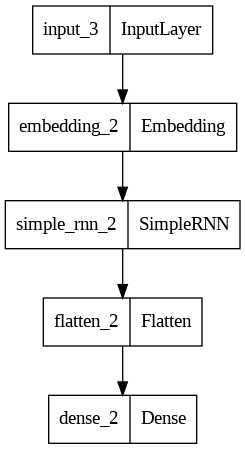

In [21]:
embedding_dim = 64

inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)

rnn_layer = tf.keras.layers.SimpleRNN(256, return_sequences=True)(embedding)

flatten = tf.keras.layers.Flatten()(rnn_layer)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(inputs, outputs)


print(model.summary())
tf.keras.utils.plot_model(model)

In [22]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    class_weight=class_weight,
    batch_size=32,
    epochs=10,
)

Epoch 1/10
525/525 [==============================] - 62s 115ms/step - loss: 1.0765 - accuracy: 0.6595 - auc: 0.6727 - val_loss: 0.4900 - val_accuracy: 0.7993 - val_auc: 0.8441
Epoch 2/10
525/525 [==============================] - 47s 89ms/step - loss: 0.5374 - accuracy: 0.8020 - auc: 0.8563 - val_loss: 0.3746 - val_accuracy: 0.8688 - val_auc: 0.9225
Epoch 3/10
525/525 [==============================] - 43s 83ms/step - loss: 0.4217 - accuracy: 0.8727 - auc: 0.9227 - val_loss: 0.6437 - val_accuracy: 0.7724 - val_auc: 0.8902
Epoch 4/10
525/525 [==============================] - 42s 80ms/step - loss: 0.3433 - accuracy: 0.9061 - auc: 0.9479 - val_loss: 0.4465 - val_accuracy: 0.9171 - val_auc: 0.9374
Epoch 5/10
525/525 [==============================] - 44s 85ms/step - loss: 1.8277 - accuracy: 0.7763 - auc: 0.8092 - val_loss: 1.4458 - val_accuracy: 0.5995 - val_auc: 0.7386
Epoch 6/10
525/525 [==============================] - 43s 81ms/step - loss: 0.6110 - accuracy: 0.8464 - auc: 0.8933 - v